In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import torch
from IPython import display

from datasets import Dataset2D
from leo import LSTMTheta

In [3]:
def plot(amplitude, phase, x_support, y_support, y_pred):
    # Plot first sequence only.
    # x has shape (num_tasks, num_support, num_frames, 2)
    x_true = np.linspace(-5, 5, 1000)
    y_true = amplitude * np.sin(x_true / phase)
    
    plt.figure(figsize=(15, 15))
    plt.plot(x_true, y_true, color="black")
    plt.plot(x_support[0, 0, :, 0], x_support[0, 0, :, 1], "ro")
    plt.scatter(y_support[0, 0, :, 0], y_support[0, 0, :, 1], facecolors='none', edgecolors='r')
    plt.plot(y_pred[0, 0, :, 0], y_pred[0, 0, :, 1], "go")
    plt.xlim((-6, 6))
    plt.ylim((-5, 5))
    plt.show()
        

In [4]:
num_support, num_query, num_frames, horizon = 1, 1, 12, 7

dataset = Dataset2D(num_support, num_query, num_frames, horizon, noise=0.0)

batch_size = 32
dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=0,
    drop_last=False,
)


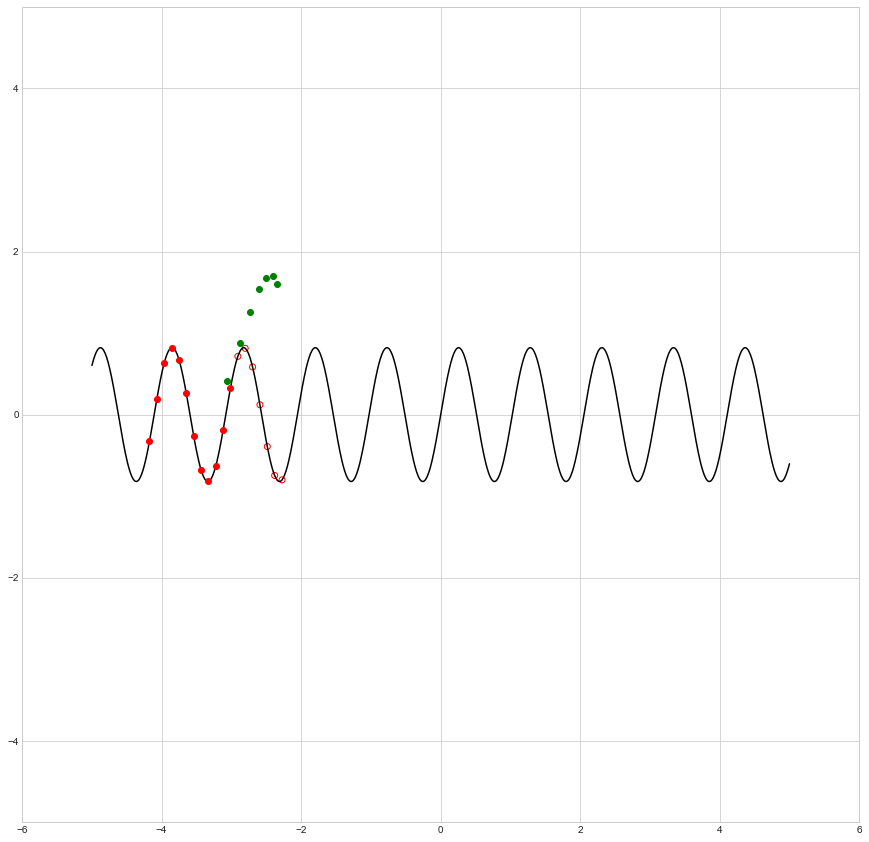

3120 tensor(0.0850, grad_fn=<MseLossBackward0>)


In [5]:
lstm = LSTMTheta(2, 32, horizon)
optimizer = torch.optim.Adam(lstm.parameters())
criterion = torch.nn.MSELoss()

num_training_tasks = 100000
for i, task_batch in enumerate(dataloader):
    x_support, y_support, _, _, (amplitude, phase) = task_batch

    out = lstm(x_support.float())
    loss = criterion(out, y_support.float())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) * batch_size > num_training_tasks:
        break

    if i % 10 == 0:
        display.clear_output(wait=True)
        plot(amplitude[0].item(), phase[0].item(), x_support, y_support, out.detach().numpy())
        print(i, loss)
